Enhancement happens as the last step

In [ ]:
!pip3 install recogym
import random
random.seed(42)
import numpy as np
from numpy.random import choice
from recogym.agents import BanditCount,OrganicCount,LogregMulticlassIpsAgent,BanditMFSquare,RandomAgent
RND_SEED = 1234
from recogym.agents import Agent
import gym, recogym

# env_0_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_args, Configuration



In [ ]:
from torch import nn, optim, Tensor

custom_args = {    
    'num_products': 10,
    'number_of_flips': 1,
    'random_seed': np.random.randint(2 ** 31 - 1),
    'select_randomly': False,
    'poly_degree': 2,
    'solver': 'lbfgs',
    'max_iter': 5000,
    'with_ps_all': False,
    'embed_dim': 5,
    'mini_batch_size': 32,
    'loss_function': nn.BCEWithLogitsLoss(),
    'optim_function': optim.RMSprop,
    'learning_rate': 0.01,
    'with_ps_all': False
}
config = Configuration({ 
        **env_1_args,
        **custom_args,
})


In [ ]:
# Define an Agent class.





class PopularityAgent(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(PopularityAgent, self).__init__(config)

        # Track number of times each item viewed in Organic session.
        self.organic_views = np.zeros(self.config.num_products)

    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""

        # Adding organic session to organic view counts.
        if observation:
            for session in observation.sessions():
                self.organic_views[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""

        # Choosing action randomly in proportion with number of views.
        prob = self.organic_views / sum(self.organic_views)
        action = choice(self.config.num_products, p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action]
            }
        }

In [ ]:
# You can overwrite environment arguments here:
env_1_args['random_seed'] = 42

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

# .reset() env before each episode (one episode per user).
env.reset()
done = False

# Counting how many steps.
i = 0

observation, reward, done = None, 0, False
while not done:
    action, observation, reward, done, info = env.step_offline(observation, reward, done)
    print(f"Step: {i} - Action: {action} - Observation: {observation.sessions()} - Reward: {reward}")
    i += 1

Step: 0 - Action: None - Observation: [{'t': 0, 'u': 0, 'z': 'pageview', 'v': 0}] - Reward: None
Step: 1 - Action: {'t': 1, 'u': 0, 'a': 3, 'ps': 0.1, 'ps-a': ()} - Observation: [] - Reward: 0
Step: 2 - Action: {'t': 2, 'u': 0, 'a': 4, 'ps': 0.1, 'ps-a': ()} - Observation: [] - Reward: 0
Step: 3 - Action: {'t': 3, 'u': 0, 'a': 5, 'ps': 0.1, 'ps-a': ()} - Observation: [] - Reward: 0


In [ ]:

popularity_agent = PopularityAgent(config)
# Train on 100 users online and track click through rate.
num_online_users = 100
num_clicks, num_events = 0, 0
popularity_agent_result = []
num_offline_users = 1000
for _ in range(num_offline_users):

    # Reset env and set done to False.
    env.reset()
    done = False

    observation, reward, done = None, 0, False
    action, observation, reward, done, info = env.step_offline(observation, reward, done)
    while not done:
        old_observation = observation
        action, observation, reward, done, info = env.step_offline(observation, reward, done)
        popularity_agent.train(old_observation, action, reward, done)

for _ in range(num_online_users):

    # Reset env and set done to False.
    env.reset()
    observation, _, done, _ = env.step(None)
    reward = None
    done = None
    while not done:
        action = popularity_agent.act(observation, reward, done)
        observation, reward, done, info = env.step(action['a'])

        # Used for calculating click through rate.
        num_clicks += 1 if reward == 1 and reward is not None else 0
        num_events += 1
        popularity_agent_result.append(num_clicks/num_events)

ctr = num_clicks / num_events

print(f"Click Through Rate: {ctr:.10f}")



Click Through Rate: 0.0128012917


In [ ]:

bandit_mf_square = BanditMFSquare(config)
# Train on 100 users online and track click through rate.
num_online_users = 100
num_clicks, num_events = 0, 0
bandit_mf_square_result = []
num_offline_users = 1000
for _ in range(num_offline_users):

    # Reset env and set done to False.
    env.reset()
    done = False

    observation, reward, done = None, 0, False
    action, observation, reward, done, info = env.step_offline(observation, reward, done)
    while not done:
        old_observation = observation
        action, observation, reward, done, info = env.step_offline(observation, reward, done)
        bandit_mf_square.train(old_observation, action, reward, done)

for _ in range(num_online_users):

    # Reset env and set done to False.
    env.reset()
    observation, _, done, _ = env.step(None)
    reward = None
    done = None
    while not done:
        action = bandit_mf_square.act(observation, reward, done)
        observation, reward, done, info = env.step(action['a'])

        # Used for calculating click through rate.
        num_clicks += 1 if reward == 1 and reward is not None else 0
        num_events += 1
        bandit_mf_square_result.append(num_clicks/num_events)

ctr = num_clicks / num_events

print(f"Click Through Rate: {ctr:.10f}")



Click Through Rate: 0.0147605904


In [ ]:
bandit_count = BanditCount(config)
num_offline_users = 1000
for _ in range(num_offline_users):

    # Reset env and set done to False.
    env.reset()
    done = False

    observation, reward, done = None, 0, False
    action, observation, reward, done, info = env.step_offline(observation, reward, done)
    while not done:
        old_observation = observation
        action, observation, reward, done, info = env.step_offline(observation, reward, done)
        bandit_count.train(old_observation, action, reward, done)
# Train on 100 users online and track click through rate.
num_online_users = 100
num_clicks, num_events = 0, 0
bandit_count_result = []
for _ in range(num_online_users):

    # Reset env and set done to False.
    env.reset()
    observation, _, done, _ = env.step(None)
    reward = None
    done = None
    while not done:
        action = bandit_count.act(observation, reward, done)
        observation, reward, done, info = env.step(action['a'])

        # Used for calculating click through rate.
        num_clicks += 1 if reward == 1 and reward is not None else 0
        num_events += 1
        bandit_count_result.append(num_clicks/num_events)

ctr = num_clicks / num_events

print(f"Click Through Rate: {ctr:.10f}")



Click Through Rate: 0.0141914602


In [ ]:
random_agent = RandomAgent(config)
# Train on 100 users online and track click through rate.
num_online_users = 100
num_clicks, num_events = 0, 0
random_agent_result = []
for _ in range(num_online_users):

    # Reset env and set done to False.
    env.reset()
    observation, _, done, _ = env.step(None)
    reward = None
    done = None
    while not done:
        action = random_agent.act(observation, reward, done)
        observation, reward, done, info = env.step(action['a'])

        # Used for calculating click through rate.
        num_clicks += 1 if reward == 1 and reward is not None else 0
        num_events += 1
        random_agent_result.append(num_clicks/num_events)

ctr = num_clicks / num_events

print(f"Click Through Rate: {ctr:.10f}")



Click Through Rate: 0.0119196989


In [ ]:


class MultiArmedBandit(Agent):
    def __init__(self, config):
      l = []
      l.append(BanditCount(config))
      l.append(BanditMFSquare(config))
      l.append(PopularityAgent(config))
      self.bandits = l
      self.epsilon = 1
      #self.weights = [1/len(self.bandits)]*len(self.bandits)
      self.click_counts = [0,0,0]
      self.call_counts = [0,0,0]
      self.weights = [0]*len(self.bandits)
      print(self.weights)
      
    def train(self, observation, action, reward, done):
      for agent in self.bandits:
        agent.train(observation,action,reward,done)
    
    def act(self, observation, reward, done):
      if random.random()<self.epsilon:
        index = random.choices([0,1,2], weights=(1,1,1), k=1)
        agent = self.bandits[index[0]]
        self.call_counts[index[0]]+=1
        index = index[0]
      else:
        max_value = max(self.weights)
        index = self.weights.index(max_value)
        agent = self.bandits[index]
        self.call_counts[index]+=1
      action = agent.act(observation,reward,done)
      if(sum(self.click_counts)!=0):
        self.epsilon = 1/sum(self.click_counts)
      return action,index

In [ ]:
multi_armed_bandit = MultiArmedBandit(config)
num_offline_users = 1000


[0, 0, 0]


In [ ]:
for _ in range(num_offline_users):

    # Reset env and set done to False.
    env.reset()
    done = False

    observation, reward, done = None, 0, False
    action, observation, reward, done, info = env.step_offline(observation, reward, done)
    while not done:
        old_observation = observation
        action, observation, reward, done, info = env.step_offline(observation, reward, done)
        multi_armed_bandit.train(old_observation, action, reward, done)


In [ ]:
# Train on 100 users online and track click through rate.
num_online_users = 100
num_clicks, num_events = 0, 0
bandit_result = []
for _ in range(num_online_users):

    # Reset env and set done to False.
    env.reset()
    observation, _, done, _ = env.step(None)
    reward = None
    done = None
    while not done:
        action,index = multi_armed_bandit.act(observation, reward, done)
        observation, reward, done, info = env.step(action['a'])
        if(reward==1):
          multi_armed_bandit.click_counts[index]+=1
        for i in range(3):
          if(multi_armed_bandit.call_counts[i]!=0):
            multi_armed_bandit.weights[i]=multi_armed_bandit.click_counts[i]/multi_armed_bandit.call_counts[i]

        # Used for calculating click through rate.
        num_clicks += 1 if reward == 1 and reward is not None else 0
        num_events += 1
        bandit_result.append(num_clicks/num_events)

ctr = num_clicks / num_events

print(f"Click Through Rate: {ctr:.10f}")

Click Through Rate: 0.0153680237


In [ ]:
print(multi_armed_bandit.weights)

[0.014705882352941176, 0.015429934072099874, 0.013071895424836602]


In [ ]:
print(num_events)

7418


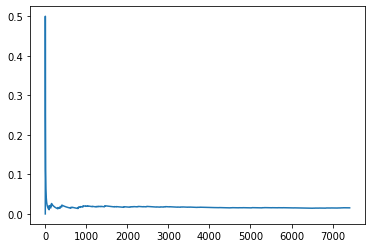

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ypoints = np.array(bandit_result)

plt.plot(ypoints)


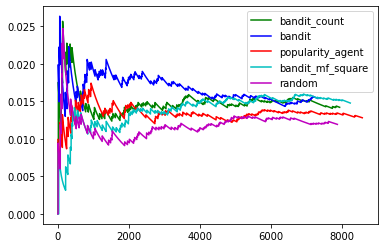

In [ ]:
bandit_result = np.array(bandit_result[100:])
bandit_count_result = np.array(bandit_count_result[100:])
popularity_agent_result = np.array(popularity_agent_result[100:])
bandit_mf_square_result = np.array(bandit_mf_square_result[100:])
random_agent_result = np.array(random_agent_result[100:])
plt.plot(bandit_count_result,color='green',label='bandit_count')
plt.plot(bandit_result,color='blue',label='bandit')
plt.plot(popularity_agent_result,color='red',label='popularity_agent')
plt.plot(bandit_mf_square_result,color='c',label='bandit_mf_square')
plt.plot(random_agent_result,color='m',label='random')
plt.legend()

plt.show()


Changing the rate to epsilon change to gain an advantage which allows more exploration initially and finally settling to exploit


In [ ]:
class BetterMultiArmedBandit(Agent):
    def __init__(self, config):
      l = []
      l.append(BanditCount(config))
      l.append(BanditMFSquare(config))
      l.append(PopularityAgent(config))
      self.bandits = l
      self.epsilon = 1
      #self.weights = [1/len(self.bandits)]*len(self.bandits)
      self.click_counts = [0,0,0]
      self.call_counts = [0,0,0]
      self.weights = [0]*len(self.bandits)
      print(self.weights)
      
    def train(self, observation, action, reward, done):
      for agent in self.bandits:
        agent.train(observation,action,reward,done)
    
    def act(self, observation, reward, done):
      if random.random()<self.epsilon:
        index = random.choices([0,1,2], weights=(1,1,1), k=1)
        agent = self.bandits[index[0]]
        self.call_counts[index[0]]+=1
        index = index[0]
      else:
        max_value = max(self.weights)
        index = self.weights.index(max_value)
        agent = self.bandits[index]
        self.call_counts[index]+=1
      action = agent.act(observation,reward,done)
      #if(sum(self.click_counts)!=0):
      #  self.epsilon = 1/(sum(self.click_counts))
      return action,index

from torch import nn, optim, Tensor

custom_args = {    
    'num_products': 10,
    'number_of_flips': 1,
    'random_seed': np.random.randint(2 ** 31 - 1),
    'select_randomly': False,
    'poly_degree': 2,
    'solver': 'lbfgs',
    'max_iter': 5000,
    'with_ps_all': False,
    'embed_dim': 5,
    'mini_batch_size': 32,
    'loss_function': nn.BCEWithLogitsLoss(),
    'optim_function': optim.RMSprop,
    'learning_rate': 0.01,
    'with_ps_all': False
}
config = Configuration({ 
        **env_1_args,
        **custom_args,
})

multi_armed_bandit = BetterMultiArmedBandit(config)
num_offline_users = 1000

for _ in range(num_offline_users):

    # Reset env and set done to False.
    env.reset()
    done = False

    observation, reward, done = None, 0, False
    action, observation, reward, done, info = env.step_offline(observation, reward, done)
    while not done:
        old_observation = observation
        action, observation, reward, done, info = env.step_offline(observation, reward, done)
        multi_armed_bandit.train(old_observation, action, reward, done)

# Train on 100 users online and track click through rate.
num_online_users = 100
num_clicks, num_events = 0, 0
better_bandit_result = []
for i in range(num_online_users):

    # Reset env and set done to False.
    env.reset()
    observation, _, done, _ = env.step(None)
    reward = None
    done = None
    while not done:
        action,index = multi_armed_bandit.act(observation, reward, done)
        observation, reward, done, info = env.step(action['a'])
        if(reward==1):
          multi_armed_bandit.click_counts[index]+=1
        for i in range(3):
          if(multi_armed_bandit.call_counts[i]!=0):
            multi_armed_bandit.weights[i]=multi_armed_bandit.click_counts[i]/multi_armed_bandit.call_counts[i]

        # Used for calculating click through rate.
        num_clicks += 1 if reward == 1 and reward is not None else 0
        num_events += 1
        better_bandit_result.append(num_clicks/num_events)
    if(i!=0):
      multi_armed_bandit.epsilon = 1/i*0.5

ctr = num_clicks / num_events

print(f"Click Through Rate: {ctr:.10f}")

[0, 0, 0]
Click Through Rate: 0.0176670177


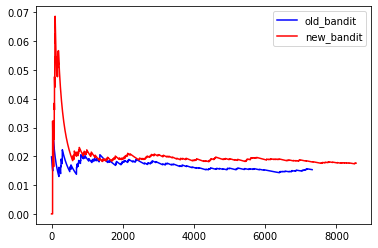

In [ ]:
bandit_result = np.array(bandit_result)
better_bandit_result = np.array(better_bandit_result)
plt.plot(bandit_result,color='blue',label='old_bandit')
plt.plot(better_bandit_result,color='red',label='new_bandit')
plt.legend()

plt.show()


In [ ]:
print(multi_armed_bandit.weights)

[0.008915304606240713, 0.016396642592231114, 0.012442698100851343]
